In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy import stats
from scipy import integrate
from celluloid import Camera
from bayes_opt import BayesianOptimization
import json
import seaborn as sns
import White_class
from scipy import special

In [2]:
main_detune = 18.7
sideband_detune = 120
white_detune = 15
beta_1 = 0.69
beta_2 = 1.98
laseron = 171312
laseroff = 505566


test = White_class.Whitelight(main_detune,sideband_detune,white_detune, beta_1,beta_2,laseron,laseroff)

In [3]:
test.motion_trace()

TypeError: 'NoneType' object is not iterable

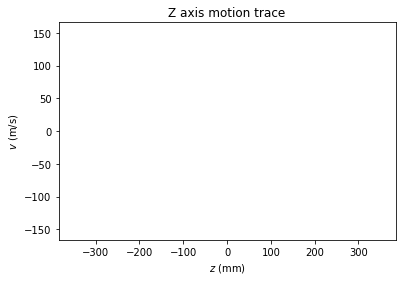

In [4]:
test.plot()

In [5]:
test.percentage()

0.04220499367260567

In [6]:
#Main variables

MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.0005/x0
dv = 0.05
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [7]:
#Define the zero magnetic field.
    
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
# magField = np.zeros(3,)

In [8]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussain_Beam_Diagonal(R:np.array,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):

        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    laserBeams = pylcp.laserBeams()
    
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)}])
    return laserBeams

In [11]:
def slow_bayesian(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff)
    magField = pylcp.quadrupoleMagneticField(mag_field_grad)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    
    def Capture_velocity_condition(t,y,threshold = 5.810):
        if y[-6]<threshold:
            val = -1.
        else:
            val = 1.
        return val
    def Lost_condition(t,y,threshold = 0.):
        if y[-6]<threshold:
            val = -1.
        else:
            val = 1.
        return val
    def for_transverse_condition(t,y,threshold = -0.020/x0):
        if y[-3]>threshold:
            val = -1.
        else:
            val = 1.
        return val

    Capture_velocity_condition.terminal = False
    Lost_condition.terminal = False
    for_transverse_condition.terminal = False
    conditions =  [for_transverse_condition,Lost_condition,Capture_velocity_condition]
    
    v_longitudinal = np.linspace(14,21,16)
    time_final = list()
    v_trap_initial = list()
    
    for v0_longitudinal in v_longitudinal:
        rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_longitudinal/np.sqrt(2),v0_longitudinal/np.sqrt(2),0]))
        rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,max_step=1e5,progress_bar = 0,method='LSODA')
        sol = rateeq.sol
        # print(sol.t_events)
        if len(sol.t_events[0])==1:
            if len(sol.t_events[1])==0:
                if len(sol.t_events[2])==1:
                    time_final.append(sol.t_events[0][0])
                    v_trap_initial.append(sol.v[0][0])
            
            
                    
    # print(v_trap_initial)
    # print(time_final)
                    
    if len(time_final)<=1:
        # print("NO results")
        return 0.
    
    def time_vs_v_final(vff):
        if vff>= min(v_trap_initial) and vff<=max(v_trap_initial):
            return np.interp(vff,v_trap_initial,time_final)

    def v_transverse_vs_v_traverse(vfs):
        return (6.00/time_vs_v_final(vfs)*1e-3/t0)

    muf = 140/v0
    sigf = 17/v0
    mut = 0
    sigt = 18.7564/v0

    def Transverse_percentage(v):
        rv = stats.norm(mut,sigt) # Gaussian of transverse, v0 scale
        val = (rv.cdf(v_transverse_vs_v_traverse(v))-rv.cdf(0))/rv.cdf(sigt*2)*2

        if val >= 1:
            return 1
        else:
            return val

    def total_func(v):
        rv_f = stats.norm(muf,sigf) # Gaussian of forward, v0 scale
        return Transverse_percentage(v)*rv_f.pdf(v)

    return integrate.quad(total_func,v_trap_initial[0],v_trap_initial[-1],limit=100)[0]

In [12]:
start = time.time()

print(slow_bayesian(18.7,120,15,0.69,1.98,171312,505566))

print(time.time()-start)

0.04233822160541753
252.87905716896057


In [13]:
pbounds = {'main_det':(10,20),'det_1':(70,170),'det_2':(5,30),'beta_1':(0,2),'beta_2':(0,5),'laseron':(138240,300000),'laseroff':(300001,600000)}

In [14]:
optimizer = BayesianOptimization(
    f = slow_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [15]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.834    |  3.602    |  70.01    |  12.56    |  3.44e+05 |  1.532e+0 |  11.86    |
|  2        |  0.003175 |  0.4479   |  4.835    |  123.4    |  23.71    |  5.496e+0 |  1.88e+05 |  15.54    |
460.5273668766022


In [16]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_Expected_model.json',reset=False)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [17]:
start = time.time()
optimizer.maximize(
    init_points=5,
    n_iter=10,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  3        |  0.04086  |  0.6911   |  1.984    |  123.9    |  15.48    |  5.056e+0 |  1.713e+0 |  18.78    |
|  4        |  0.002666 |  0.05478  |  3.352    |  111.7    |  18.97    |  3.421e+0 |  1.703e+0 |  18.01    |
|  5        |  0.0      |  1.937    |  1.567    |  139.2    |  26.91    |  5.684e+0 |  1.52e+05 |  10.39    |
|  6        |  0.007926 |  0.3397   |  4.391    |  79.83    |  15.53    |  5.874e+0 |  2.245e+0 |  16.92    |
|  7        |  0.03598  |  0.631    |  3.433    |  153.5    |  5.457    |  5.25e+05 |  2.982e+0 |  17.48    |
|  8        |  0.000631 |  1.963    |  4.516    |  95.45    |  28.54    |  4.752e+0 |  1.694e+0 |  12.72    |
|  9        |  0.007603 |  1.93     |  0.3315   |  75.22    |  20.29    |  4.737e+0 |  2.775e+0 |  14.03    |
|  10     

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=10,
    n_iter=50,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
